In [1]:
import numpy as np
import cv2
import pandas as pd
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

In [2]:
image_path = "Data_ml"
image_files = os.listdir(f"{image_path}/images")
image_files

['20170726235030Lh_02.jpeg',
 '20130213063454Uh_01.jpeg',
 '20140414195834Ch_02.jpeg',
 '20111018063134Lh_03.jpeg',
 '20180112130330Ch_03.jpeg',
 '20130923060834Lh_03.jpeg',
 '20190412025430Lh_03.jpeg',
 '20121203063334Lh_02.jpeg',
 '20160327170714Mh_01.jpeg',
 '20210222222850Bh_01.jpeg']

In [3]:
label_files = []
for x in image_files:
  label_files.append(f"{x.split('.')[0]}.png")
label_files

['20170726235030Lh_02.png',
 '20130213063454Uh_01.png',
 '20140414195834Ch_02.png',
 '20111018063134Lh_03.png',
 '20180112130330Ch_03.png',
 '20130923060834Lh_03.png',
 '20190412025430Lh_03.png',
 '20121203063334Lh_02.png',
 '20160327170714Mh_01.png',
 '20210222222850Bh_01.png']

In [4]:
#feature extractor

def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img.reshape(-1)
    df = pd.DataFrame()
    df['Original Image'] = img2

    # Add Gabor features
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    gabor_label = 'Gabor' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    num += 1

    # Add edge features
    df['Canny Edge'] = cv2.Canny(img, 100, 200).reshape(-1)
    df['Roberts'] = roberts(img).reshape(-1)
    df['Sobel'] = sobel(img).reshape(-1)
    df['Scharr'] = scharr(img).reshape(-1)
    df['Prewitt'] = prewitt(img).reshape(-1)

    # Add filters
    df['Gaussian s3'] = nd.gaussian_filter(img, sigma=3).reshape(-1)
    df['Gaussian s7'] = nd.gaussian_filter(img, sigma=7).reshape(-1)
    df['Median s3'] = nd.median_filter(img, size=3).reshape(-1)
    df['Variance s3'] = nd.generic_filter(img, np.var, size=3).reshape(-1)

    return df

In [5]:
#only using image as image size is 2048x2048 there is an exponential increase in data samples

all_images_df = pd.DataFrame()
i = 0
for img_path, label_path in tqdm(zip(image_files, label_files), total=len(image_files)):
    i += 1
    # Extract features from the image
    img_df = extract_features(f"{image_path}/images/{img_path}")

    # Load and process the corresponding label image
    labeled_img = cv2.imread(f"{image_path}/masks/{label_path}")
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)
    labeled_img1 = labeled_img.reshape(-1)

    # Add labels to the image features dataframe
    img_df['Labels'] = labeled_img1

    # Concatenate to the main dataframe
    all_images_df = pd.concat([all_images_df, img_df], ignore_index=True)
    if i == 1:
      break
print(all_images_df.shape)
all_images_df.head()

  0%|          | 0/10 [01:42<?, ?it/s]

(4194304, 43)


,Original Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Canny Edge,Roberts,Sobel,Scharr,Prewitt,Gaussian s3,Gaussian s7,Median s3,Variance s3,Labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [14]:
all_images_df = pd.read_csv('all_images_train.csv')

In [15]:
Y = all_images_df["Labels"].values

X = all_images_df.drop(labels = ["Labels"], axis=1)

In [9]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

Training Random Forest Models: 100%|██████████| 4/4 [28:42<00:00, 430.67s/it]


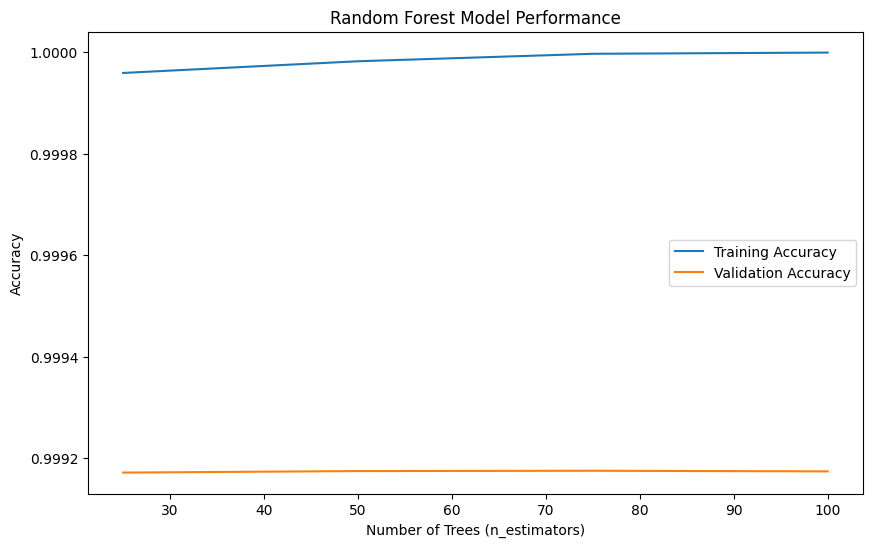

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Example range of n_estimators
n_estimators_range = [25, 50, 75, 100]

# Lists to store metrics
train_accuracies = []
validation_accuracies = []

for n_estimators in tqdm(n_estimators_range, desc="Training Random Forest Models"):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Record training accuracy
    train_preds = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    train_accuracies.append(train_accuracy)

    # Record validation accuracy
    validation_preds = model.predict(X_test)
    validation_accuracy = accuracy_score(y_test, validation_preds)
    validation_accuracies.append(validation_accuracy)

    filename = f"model_{n_estimators}_estimators.pkl"
    pickle.dump(model, open(filename, 'wb'))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy')
plt.plot(n_estimators_range, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest Model Performance')
plt.legend()
plt.show()

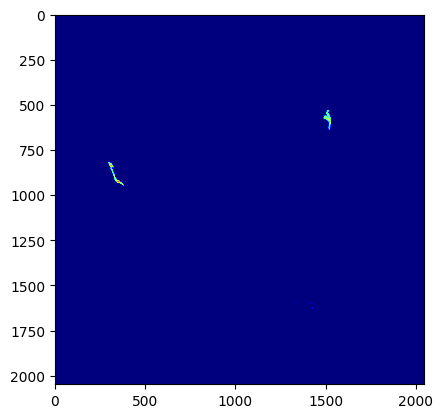

In [16]:
result = model.predict(X)

segmented = result.reshape((2048,2048))

from matplotlib import pyplot as plt
plt.imshow(segmented, cmap ='jet')
plt.imsave('segmented_rock_RF_100_estim.jpg', segmented, cmap ='jet')